In [1]:
import os
import torch
import requests
import matplotlib.pyplot as plt
from torch import nn
from utils.useful_func import *

In [2]:
def read_data_nmt():
    with open(r'../data/fra-eng/fra.txt','r',encoding='utf-8') as f:
        result=f.read()
    return result

In [3]:
#@save
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)


In [4]:
def tokenize_nmt(text,num_examples=None):
    source,target=[],[]
    for i,line in enumerate(text.split('\n')):
        if num_examples and i>=num_examples:
            break
        parts=line.split('\t')
        ## 必须得有原始和目标值所以长度得为2
        if len(parts)==2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source,target

In [5]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) >= num_steps:
        return line[:num_steps]
    return line+[padding_token]*(num_steps-len(line))

In [6]:
## 将文本数据作为批量数据，并且加入<eos>至末尾 同时统计有效字符 包含eos
def build_array_nmt(lines, vocab, num_steps):
    lines=[vocab[i] for i in lines]
    lines=[i+[vocab['<eos>']] for i in lines]
    array=torch.tensor([truncate_pad(i,num_steps,vocab['<pad>']) for i in lines])
    valid_len =(array != vocab['<pad>']).type(torch.int32).sum(dim=1)
    return array, valid_len

In [7]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    ## 结果是原始列表 列表表长度 目标列表 目标列表长度
    source, target = tokenize_nmt(preprocess_nmt(read_data_nmt()), num_examples)
    src_vocab = Vocal(source, min_feq=2,
                              reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocal(target, min_feq=2,
                              reserved_tokens=['<pad>', '<bos>', '<eos>'])
    
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True),src_vocab, tgt_vocab

In [8]:
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
    
    def init_state(self,enc_outputs,*args):
        raise NotImplementedError
    
    def forward(self,X,state):
        raise NotImplementedError

In [9]:
class Encoder(nn.Module):
    """编码器—解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
    def forward(self, X,*args):
        raise NotImplementedError

class EncoderDecoder(nn.Module):
    def __init__(self,encoder,decoder,**kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X)
        dec_state=self.decoder.init_state(enc_outputs,*args)
        return self.decoder(dec_X,dec_state)
        

In [10]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [11]:
class Seq2SeqEncoder(Encoder):
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,dropout=0,**kwargs):
        super().__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.rnn = nn.GRU(embed_size,num_hiddens,num_layers,dropout=dropout)
        
    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        ## 无初始状态则初始状态为0
        output, state = self.rnn(X)
        return output, state
        

class Seq2SeqDecoder(Decoder):
    def __init__(self,vocab_size,embed_size,num_hiddens,num_layers,dropout=0,**kwargs):
        super().__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.rnn=nn.GRU(embed_size + num_hiddens,num_hiddens,num_layers,dropout=dropout)
        self.dense=nn.Linear(num_hiddens,vocab_size)
        
    def init_state(self,enc_outputs,*args):
        return enc_outputs[1]
    
    def forward(self,X,dec_state):
        # 传入的x是 batch_size 时间步 向量大小
        X=(self.embedding(X))
        X=X.permute(1, 0, 2)
        # 广播context，使state最后时刻最后一层 具有与X相同的num_steps
        context=dec_state[-1].repeat(X.shape[0],1,1)
        X_and_context=torch.cat((X,context),dim=-1)
        output,state=self.rnn(X_and_context,dec_state)
        # output的形状:(batch_size,num_steps,vocab_size)
        output=self.dense(output).permute(1,0,2)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output,state
        

In [12]:
encoder=Seq2SeqEncoder(10,8,16,2)
encoder.eval()
X=torch.zeros((4,7),dtype=torch.long)
output,state=encoder(X)
## 7是时间步 4是batch_size, 16是隐藏层维度
output.shape
## 层数 batch_size 隐藏层维度
# state.shape

torch.Size([7, 4, 16])

In [13]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)

dec_state=decoder.init_state(encoder(X))
output,state=decoder.forward(X,dec_state)
## 4，7，10 4是batch_size 最后一个维度是词表大小 进行softmax之后 就是4 7 7是约定的时间步大小但是实际需要的会比这个要小
output.shape

torch.Size([4, 7, 10])

In [14]:
state.shape

torch.Size([2, 4, 16])

损失函数

In [15]:
def sequence_mask(X,valid_len,value=0):
    """在序列中屏蔽不相关的项"""
    # 首先x是二维的 最内层维度是句子长度 注意：是训练集所以才知道句子真实长度
    # 拿出总的长度 得到长度
    maxlen = X.shape[1]
    # 然后用总长度生成一个1维的向量 使用函数扩展成2维以便与valid_len进行广播
    mask=torch.unsqueeze(torch.arange(0, maxlen, dtype=torch.long),dim=0)
    # mask在0维度扩充 valid在1维度扩充 因为每一个valid对应的是每一个x valid的数字其实是x的第二维向量
    mask=(mask<torch.unsqueeze(valid_len,dim=1)) # 这里小于号就够了 因为<eos>所在位置的索引其实是valid_len-1
    X[~mask]=value
    return X

In [16]:
# 拓展的softmax因为对填充值进行softmax其实没有什么意义
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    def forward(self, pred, label,valid_len):
        weights=torch.ones_like(label)
        weights=sequence_mask(weights,valid_len)
        self.reduction='none'
        pred=pred.permute(0,2,1)
        unweight_loss=super().forward(pred,label)
        weights_loss=unweight_loss*weights
        return weights_loss.mean(dim=1)
        

# 训练

In [17]:
def train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer=torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    # 进入训练模式
    net.train()
    animator = Animator(xlabel='epoch', ylabel='loss',
                         xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer=Timer()
        metric=Accumulator(2)
        for batch in train_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos=torch.tensor([tgt_vocab['<bos>']]*Y.shape[0],device=device).reshape(-1,1)
            dec_input=torch.cat([bos,Y[:,:-1]],dim=1)
            y_hat,_=net(X,dec_input,X_valid_len)
            l = loss(y_hat,Y,Y_valid_len)
            l.sum().backward()
            grad_clipping(net,1)
            optimizer.step()
            num_tokens=Y_valid_len.sum()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

loss 0.019, 10445.5 tokens/sec on cpu


EncoderDecoder(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(184, 32)
    (rnn): GRU(32, 32, num_layers=2, dropout=0.1)
  )
  (decoder): Seq2SeqDecoder(
    (embedding): Embedding(201, 32)
    (rnn): GRU(64, 32, num_layers=2, dropout=0.1)
    (dense): Linear(in_features=32, out_features=201, bias=True)
  )
)

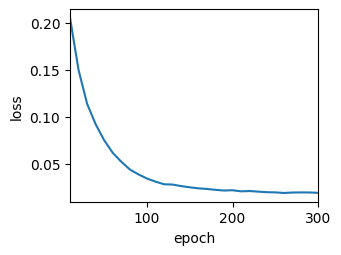

In [18]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, 'cpu'

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)
net.eval()

In [20]:
# predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)

In [21]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}')

go . => va au feu !
i lost . => j'ai perdu .
he's calm . => il court .
i'm home . => je suis chez moi qui qui mort ?


In [37]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [38]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va au feu !, bleu 0.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il court ., bleu 0.000
i'm home . => je suis chez moi qui qui mort ?, bleu 0.572
